In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
import mflow
from zdata import PdDataStats, ZPdDataset
import utilz, content, preprocess, extract
import report


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer , OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn import svm 


# 1. Load Dataset

In [3]:

pdstats = PdDataStats(
                {PdDataStats.DATA_DICT_RECORDZ_KEY: content.STARE_FUNDUS_CONTENT_FPATH,
                PdDataStats.DATA_DICT_HAS_HEADERZ_KEY: True,
                'rec_parser': utilz.FileIO.row_parser                     
                },
                 ftype=PdDataStats.TYPE_TXT_LINES_FILE ) 

pdstats.dframe.describe() 

,fname,fpath,ishape,imin,imax,imean,istd,Normal,Emboli,BRAO,...,ASR,HTR,Coats,MA,CNV,UNDEF,dcodez_id,dcodez_short,dcodez_desc,dnotes
count,397,397,397,397,397,397,397,397,397,397,...,397,397,397,397,397,397,397,397,397,210
unique,397,397,1,2,17,397,397,2,2,2,...,2,2,2,2,2,2,48,48,48,75
top,im0258,/mnt/externz/zRepoz/datasets/fundus/stare/im01...,"(605, 700, 3)",0,255,72.11228099173553,77.66639420989742,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14,UNDEF,Unknown Diagnosis,Choroidal Neovascularization AND Age Related M...
freq,1,1,397,371,373,1,1,358,384,390,...,364,361,383,389,336,239,90,90,90,33


In [4]:
N = 30
dframe = pdstats.dframe.sample(n=N) 
X_data = dframe  
y_data = dframe['Normal'].values.astype(np.float32) ##TODO: 'dcodez_short'
print("Loaded into PdFrame data of size: ", len(dframe) , " and into y_data of size ", len(y_data) )  
print( dframe.columns )
print("\n\n", X_data['fname'])

Loaded into PdFrame data of size:  30  and into y_data of size  30
Index(['fname', 'fpath', 'ishape', 'imin', 'imax', 'imean', 'istd', 'Normal',
       'Emboli', 'BRAO', 'CRAO', 'BRVO', 'CRVO', 'Hemi-CRVO', 'BDR-NPDR',
       'PDR', 'ASR', 'HTR', 'Coats', 'MA', 'CNV', 'UNDEF', 'dcodez_id',
       'dcodez_short', 'dcodez_desc', 'dnotes'],
      dtype='object')


 23     im0024
229    im0235
351    im0357
202    im0208
318    im0324
67     im0069
292    im0298
148    im0153
394    im0400
391    im0397
218    im0224
120    im0124
174    im0180
27     im0028
262    im0268
105    im0107
248    im0254
114    im0118
3      im0004
92     im0094
238    im0244
104    im0106
85     im0087
352    im0358
5      im0006
173    im0179
364    im0370
326    im0332
275    im0281
9      im0010
Name: fname, dtype: object


# 2. Pipelines and permutations

In [5]:
## 2. Data PIPELINEZ 
loader_p = [ ('fetch_img', preprocess.LoadImageFileTransform('fpath', crop_ratio=0.75) ), ]
flattenor = [ ('flatten', preprocess.Flattenor()), ]
funduzor_1 = [ ('funduzor', extract.FundusColorChannelz() ),]
lbp_adder = [ ('lbp_add', extract.FundusAddLBP(1) ),]
scaler_p = [('scaler', StandardScaler()), ]
channelz_for_scaler = [('channelz_sc',extract.ChannelzSelector( ls_channelz=(1,) ) )] 
channelz_frangi = [('channelz_fr',extract.ChannelzSelector( ls_channelz=(1,2,3,4) ) )] 
channelz_lbp = [('channelz_lb', extract.ChannelzSelector( ls_channelz=(0,2,3,4,) ) )] 


# 3. Load Images to mem - resize and crop 

30 (168, 168, 3)


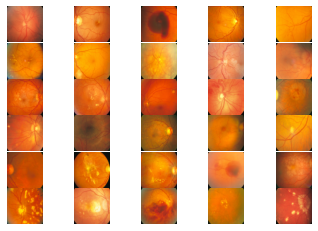

In [6]:
tmpz = Pipeline(loader_p).transform(X_data)
print( len(tmpz), tmpz[0].shape)
# _ = [print(f"{t.shape}") for t in tmpz]
utilz.Image.plot_images_list( tmpz, nc=5, cmap='gray')

# 4. Color Channel and LBP maps

30 (168, 168, 4)


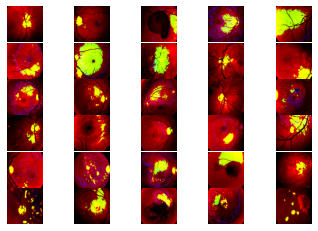

In [7]:
tmpz2 = Pipeline( funduzor_1 ).transform(tmpz)
print( len(tmpz2), tmpz2[0].shape)
utilz.Image.plot_images_list( [t[:,:,1:] for t in tmpz2], nc=5, cmap=None)

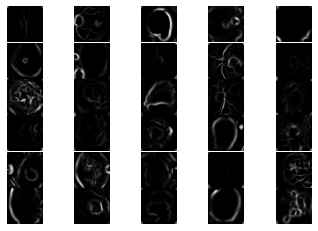

0: Min: 0.0, Max: 0.0001519010760046967
1: Min: 0.0, Max: 1.0
2: Min: 0.0, Max: 1.0
3: Min: 0.0, Max: 0.0


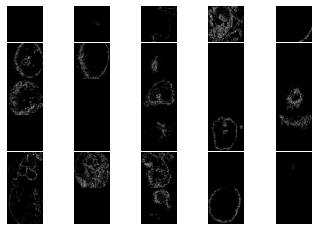

In [8]:
utilz.Image.plot_images_list( [ t[:,:,0] for t in tmpz2], nc=5, cmap='gray') #.astype('uint8')

for i in range(4):
    g = tmpz2[0][:,:,i]
    print( f"{i}: Min: {g.min()}, Max: {g.max()}")
    
utilz.Image.plot_images_list( [ t[:,:,-1].astype('uint8') for t in tmpz2], nc=5, cmap='gray') #.astype('uint8')

30 (168, 168)


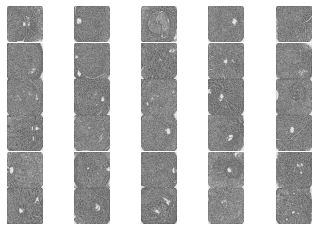

In [9]:
from skimage.feature import local_binary_pattern

lbp_radius = 1
lbp_k = 8*lbp_radius
lbp_method = 'uniform'
lbp_imgz = [ local_binary_pattern( f[:,:,1] , lbp_k, lbp_radius, lbp_method) for f in tmpz2]
print( len(lbp_imgz), lbp_imgz[0].shape)
utilz.Image.plot_images_list( lbp_imgz, nc=5, cmap='gray')


30 (168, 168, 5)


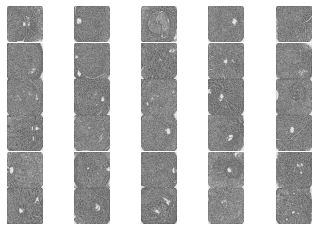

In [10]:
tmpz3 = Pipeline( loader_p+funduzor_1+lbp_adder ).transform(X_data) #+channelz_for_scaler
print( len(tmpz3), tmpz3[0].shape)
utilz.Image.plot_images_list( [t[:,:,0] for t in tmpz3], nc=5, cmap='gray')

30 (168, 168, 1)


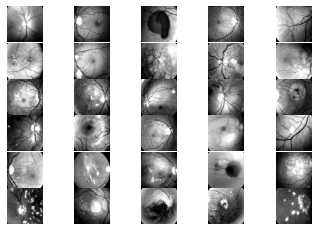

In [11]:
tmpz4 = Pipeline( loader_p+funduzor_1+channelz_for_scaler).transform(X_data) #
print( len(tmpz4), tmpz4[0].shape)
utilz.Image.plot_images_list( [t[:,:,0] for t in tmpz4], nc=5, cmap='gray')

im0024_UNDEF


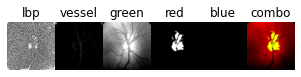

im0235_Normal


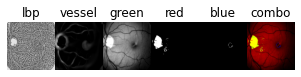

im0357_MA


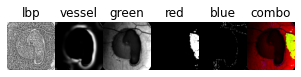

im0208_ASR


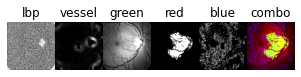

im0324_Emboli


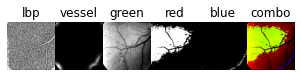

im0069_BDR-NPDR


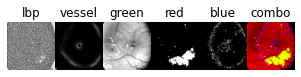

im0298_UNDEF


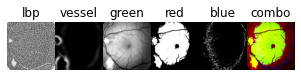

im0153_UNDEF


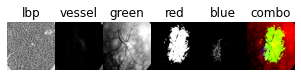

im0400_BRAO++Emboli++ASR


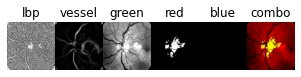

im0397_HTR


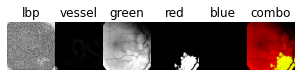

im0224_BDR-NPDR


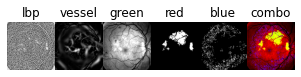

im0124_BDR-NPDR


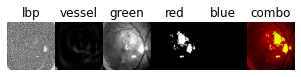

im0180_UNDEF


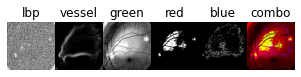

im0028_Hemi-CRVO++ASR


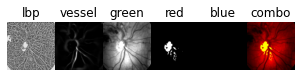

im0268_CNV++UNDEF


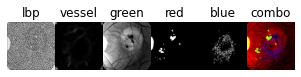

im0107_UNDEF


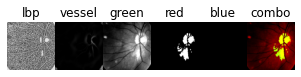

im0254_Normal


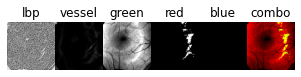

im0118_BDR-NPDR++ASR


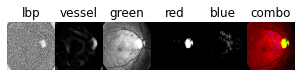

im0004_UNDEF++CRAO


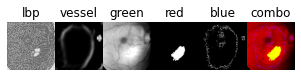

im0094_BDR-NPDR++HTR


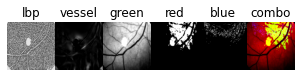

im0244_Normal


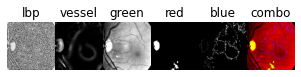

im0106_CNV++UNDEF


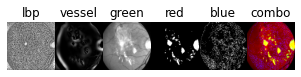

im0087_PDR


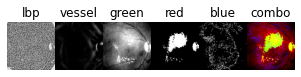

im0358_MA


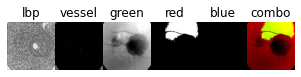

im0006_UNDEF


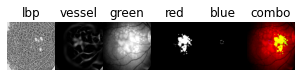

im0179_PDR


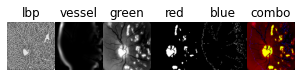

im0370_CNV++UNDEF


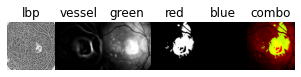

im0332_Hemi-CRVO++HTR


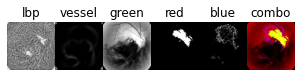

im0281_HTR


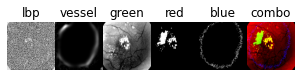

im0010_UNDEF


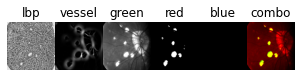

In [12]:
tz = ['lbp', 'vessel', 'green', 'red', 'blue',  'combo']
for fp, norm, colrz_lbp in zip(X_data['fname'], X_data['dcodez_short'], tmpz3):
    c = colrz_lbp.shape[2]
    imgz = [ *[ colrz_lbp[:,:,i] for i in range(c) ], colrz_lbp[:,:,2:]]
    fn = norm #_CLASSES[int(float(norm))]
    print( f"{fp}_{fn}" )
    utilz.Image.plot_images_list( imgz, titlez=tz, nc=c+2 , cmap='gray', 
                                 save= f"{fp}_{fn}" , 
                                    tdir="./output")

# 5. Permutationz

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm 

import model

In [14]:
dpipez = [
    Pipeline(loader_p+funduzor_1),
    Pipeline(loader_p+funduzor_1+lbp_adder),
]
mpipez = [ ( Pipeline(flattenor+[('svm', svm.SVC() ) ]), {'kernel':('linear', 'rbf'), 'C':[1, 10]}) ,  ## 
            ( Pipeline(flattenor+[('logit', LogisticRegression() ) ]), {'C':[1,10]} ), ##
         ]  


mgr = model.ZTrainingManager() 
mgr.build_permutationz(data_pipez=dpipez, model_pipez=mpipez)
search_output = mgr.run( X_data , y_data, train_test_split=1.)
c="*="
print(f"{c*10} End ZTrainingManager {c*10}\n {search_output[0]}")



***********svm***********
13-03-2021 14:38:35: [Perm_1 svm fetch_img__funduzor] Best score = 0.9000 estimator = Pipeline(steps=[('data_pipe',
                 Pipeline(steps=[('fetch_img',
                                  LoadImageFileTransform(crop_ratio=0.75,
                                                         fpath_colname='fpath')),
                                 ('funduzor', FundusColorChannelz())])),
                ('model_pipe',
                 Pipeline(steps=[('flatten', Flattenor()),
                                 ('svm', SVC(C=1))]))]) paramz = {'model_pipe__svm__C': 1, 'model_pipe__svm__kernel': 'rbf'}


***********svm***********
13-03-2021 14:38:51: [Perm_2 svm fetch_img__funduzor__lbp_add] Best score = 0.9000 estimator = Pipeline(steps=[('data_pipe',
                 Pipeline(steps=[('fetch_img',
                                  LoadImageFileTransform(crop_ratio=0.75,
                                                         fpath_colname='fpath')),
         

In [15]:
#search_output

<BarContainer object of 4 artists>

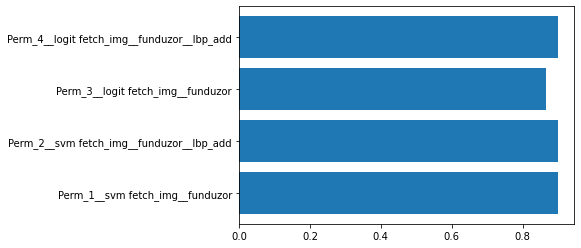

In [16]:
grp = [f"{s[0]}__{s[1]}" for s in search_output]
acc = [s[2] for s in search_output]
#error = np.random.rand(len(grp))
plt.barh( grp, acc, align='center') #xerr=error 

# 6. Eigen(Faces)


**** FIN FIT ****


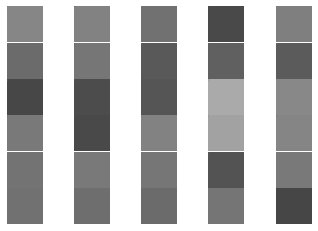

In [17]:
n_comps = 20
eigenz = extract.EigenzChannelz(g_channel=2, topn=n_comps, append_component=False)
tmpz5 = eigenz.fit_transform(tmpz3) 
utilz.Image.plot_images_list( [t for t in tmpz5], nc=5, cmap='gray')

**** FIN FIT ****
30
(168, 168, 6)


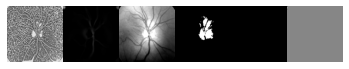

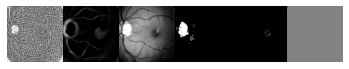

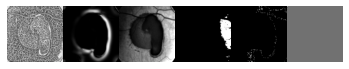

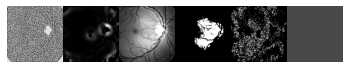

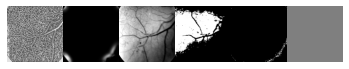

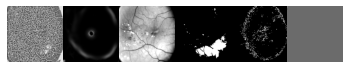

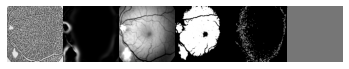

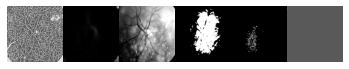

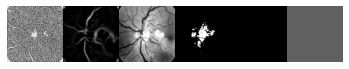

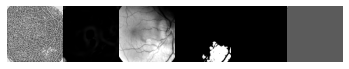

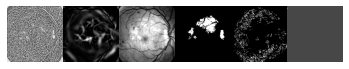

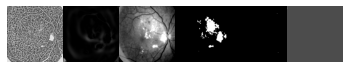

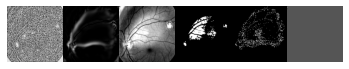

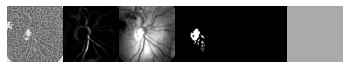

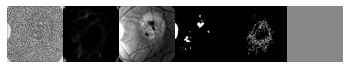

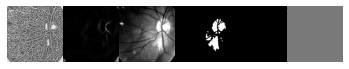

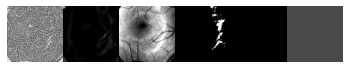

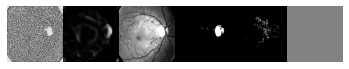

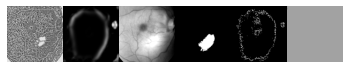

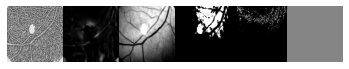

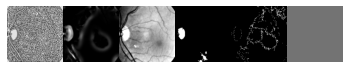

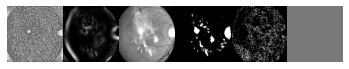

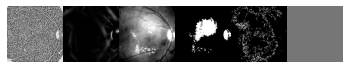

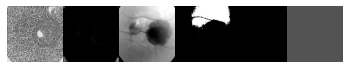

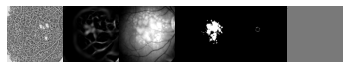

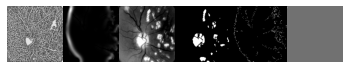

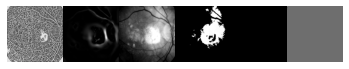

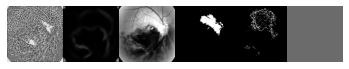

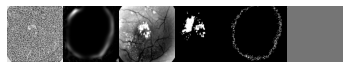

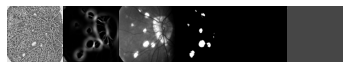

In [18]:
n_comps = 20
eigenz = extract.EigenzChannelz(g_channel=2, topn=n_comps, append_component=True)
tmpz5 = eigenz.fit_transform(tmpz3)  

print( len(tmpz5) )
print( tmpz5[0].shape)

c = tmpz5[0].shape[2]
for t in tmpz5:
    utilz.Image.plot_images_list( [ t[:,:,i] for i in range(c)], nc=c, cmap='gray')

**** FIN FIT ****
30 (168, 168, 6)
im0024_UNDEF


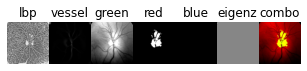

im0235_Normal


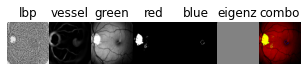

im0357_MA


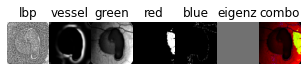

im0208_ASR


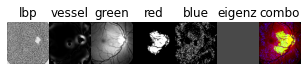

im0324_Emboli


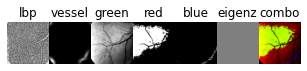

im0069_BDR-NPDR


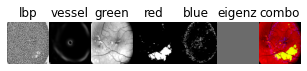

im0298_UNDEF


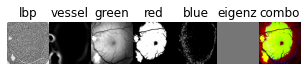

im0153_UNDEF


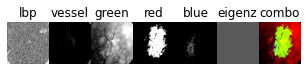

im0400_BRAO++Emboli++ASR


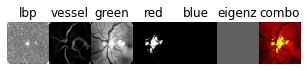

im0397_HTR


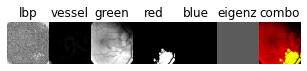

im0224_BDR-NPDR


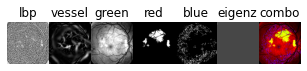

im0124_BDR-NPDR


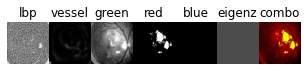

im0180_UNDEF


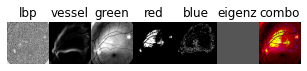

im0028_Hemi-CRVO++ASR


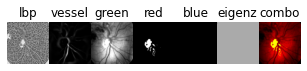

im0268_CNV++UNDEF


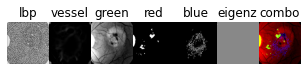

im0107_UNDEF


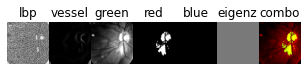

im0254_Normal


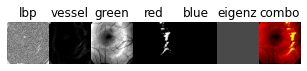

im0118_BDR-NPDR++ASR


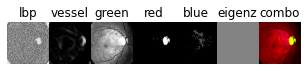

im0004_UNDEF++CRAO


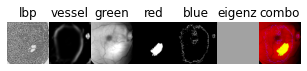

im0094_BDR-NPDR++HTR


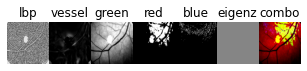

im0244_Normal


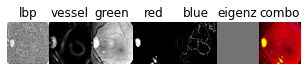

im0106_CNV++UNDEF


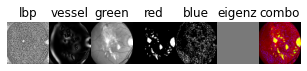

im0087_PDR


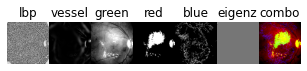

im0358_MA


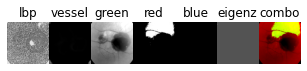

im0006_UNDEF


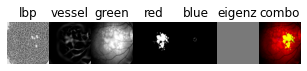

im0179_PDR


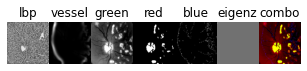

im0370_CNV++UNDEF


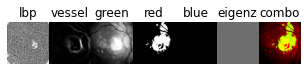

im0332_Hemi-CRVO++HTR


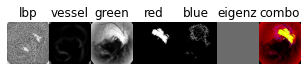

im0281_HTR


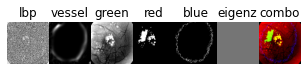

im0010_UNDEF


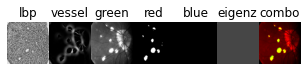

In [21]:
tmpz7 = Pipeline( loader_p+funduzor_1+lbp_adder+[('eigenz', eigenz),] ).fit_transform(X_data) #+channelz_for_scaler
print( len(tmpz7), tmpz7[0].shape)

tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'eigenz', 'combo']
for fp, norm, colrz_lbp in zip(X_data['fname'], X_data['dcodez_short'], tmpz7):
    c = colrz_lbp.shape[2]
    imgz = [ *[ colrz_lbp[:,:,i] for i in range(c) ], colrz_lbp[:,:,2:-1]]
    fn = norm #_CLASSES[int(float(norm))]
    print( f"{fp}_{fn}" )
    utilz.Image.plot_images_list( imgz, titlez=tz, nc=c+2 , cmap='gray', 
                                 save= f"{fp}_{fn}" , 
                                    tdir="./output")